In [1]:
#Imports
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary

import torch.nn.functional as F
import matplotlib.pyplot as plt

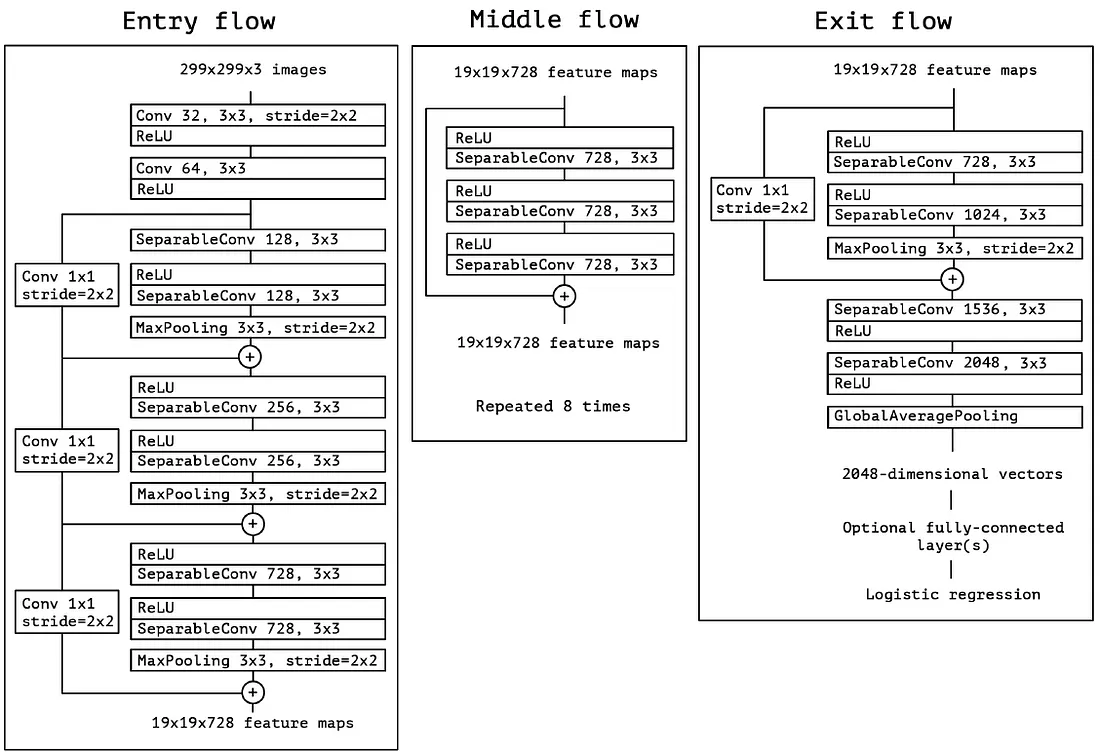

In [2]:

class Conv_bn(nn.Module):
  def __init__(self,input_channels,out,ks,s=1):
    super().__init__() 
    self.conv=nn.Conv2d(in_channels=input_channels,out_channels=out,kernel_size=ks,stride=s,padding=(ks-1)//2,bias=False)
    self.bn=nn.BatchNorm2d(out)
  def forward(self,x):
    x=self.conv(x)
    x=self.bn(x)
    return x

class Sep_bn(nn.Module):
  def __init__(self,input_channels,out,ks,s=1):
     super().__init__() 
     self.depthwise=nn.Conv2d(input_channels, input_channels, kernel_size=ks, padding=(ks-1)//2, groups=input_channels,bias=False)
     self.pointwise = nn.Conv2d(input_channels, out, kernel_size=1,bias='false')
     self.bn=nn.BatchNorm2d(out)
  def forward(self,x):
    
    x=self.depthwise(x)  
    x=self.pointwise(x)
    x=self.bn(x)
    return x

class Entryflow(nn.Module):
   def __init__(self,input_channels=3):
     super().__init__() 
     self.conv1=Conv_bn(input_channels,32,3,2)
     self.conv2=Conv_bn(32,64,3)
     self.sepconv1= Sep_bn(64,128,3)
     self.sepconv2=Sep_bn(128,128,3)
     self.maxpooling1=nn.MaxPool2d(3, stride=2,padding=1)
     self.skipconv1=Conv_bn(64,128,1,2)

     self.sepconv3=Sep_bn(128,256,3)
     self.sepconv4=Sep_bn(256,256,3)   
     self.maxpooling2=nn.MaxPool2d(3, stride=2,padding=1)
     self.skipconv2=Conv_bn(128,256,1,2)


     self.sepconv5=Sep_bn(256,728,3)
     self.sepconv6=Sep_bn(728,728,3)   
     self.maxpooling3=nn.MaxPool2d(3, stride=2,padding=1)
     self.skipconv3=Conv_bn(256,728,1,2)

   def forward(self,x):
     x=F.relu(self.conv1(x))
     
     skip=F.relu(self.conv2(x))
     x=F.relu(self.sepconv1(skip))
     x=self.sepconv2(x)
     x=self.maxpooling1(x)
     skip=self.skipconv1(skip)
     x=F.relu(skip+x)
     x=F.relu(self.sepconv3(x))
     x=self.sepconv4(x)
     x=self.maxpooling2(x)

     skip=self.skipconv2(skip)

     x=F.relu(skip+x)
     x=F.relu(self.sepconv5(x))
     x=self.sepconv6(x)
     x=self.maxpooling3(x)

     skip=self.skipconv3(skip)
     x=skip+x

     return x


class MiddleflowBlock(nn.Module):
  def __init__(self,input_channels=728):
      super().__init__()
      self.sepconv1= Sep_bn(input_channels,728,3)
      self.sepconv2= Sep_bn(input_channels,728,3)
      self.sepconv3= Sep_bn(input_channels,728,3)

  def forward(self,input):
    x=F.relu(input)
    x=F.relu(self.sepconv1(x))
    x=F.relu(self.sepconv2(x))
    x=self.sepconv3(x)
    out=input+x

    return out



def middleflow():
  mid=MiddleflowBlock(728)
  layers=[]
  for _ in range(8):
    layers.append(mid)
  output=nn.Sequential(*layers)
  return output


class Exitflow(nn.Module):
  def __init__(self,input_channels=728,n_classes=1000):
    super().__init__()
    self.sepconv1= Sep_bn(input_channels,728,3)
    self.sepconv2= Sep_bn(728,1024,3)
    self.maxpooling1=nn.MaxPool2d(3, stride=2,padding=1)
    self.skipconv1=Conv_bn(728,1024,1,2)

    self.sepconv3= Sep_bn(1024,1536,3)
    self.sepconv4= Sep_bn(1536,2048,3)
    self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(2048,1000)
    self.softmax=nn.Softmax(dim=1)

  def forward(self,input):
    x=F.relu(input)
   
    x=F.relu(self.sepconv1(x))

    x=self.sepconv2(x)
    x= self.maxpooling1(x)
   
    
    skip= self.skipconv1(input)
  
    x=skip+x
    x=F.relu(self.sepconv3(x))
    x=F.relu(self.sepconv4(x))
    x=self.global_avg_pool(x)
    x=self.flatten(x)
    x=self.softmax(self.linear(x))

    return x

class Xception(nn.Module):
   def __init__(self,input_channels=3,num_classes=1000):
     super().__init__()
     self.entry_flow= Entryflow(input_channels)
     self.middle_flow= middleflow()
     self.exit_flow=Exitflow(n_classes=num_classes)
   def forward(self,x):
     x=self.entry_flow(x)
     x=self.middle_flow.forward(x)
     x=self.exit_flow(x)

     return x






In [3]:
input_sample = torch.rand((1,3, 299, 299))
model=Xception()
out=model(input_sample)
print(out.shape)

torch.Size([1, 1000])


In [4]:
model

Xception(
  (entry_flow): Entryflow(
    (conv1): Conv_bn(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv_bn(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (sepconv1): Sep_bn(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (sepconv2): Sep_bn(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=